In [40]:
import torch
import random
import numpy as np
from collections import deque
from simulation import Simulation
from constants import *
from model import QNet, QTrainer
import matplotlib.pyplot as plt
import tqdm

In [41]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
LR = 0.001

In [42]:

class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = QNet(6*N_PM+5*N_APPS+N_APPS*N_PM, 512, N_APPS*N_PM)
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)


    def get_state(self, simulation: Simulation):
        return np.array(simulation.getState())

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state)) # popleft if MAX_MEMORY is reached

    def train_short_memory(self, state, action, reward, next_state):
        self.trainer.train_step(state, action, reward, next_state)

    def get_action(self, state):
        # random moves: tradeoff exploration / exploitation
        self.epsilon = 350 - self.n_games # TODO change epsilon
        self.n_games += 1
        final_move = np.zeros(N_APPS*N_PM)
        
        if random.randint(0, 200) < self.epsilon:
            for i in range(N_APPS):
                sum = 0
                for j in range(1,N_PM):
                    if np.random.rand() < 0.5:
                        final_move[i*N_PM+j] = 1
                        sum += 1
                if sum == 0:
                    continue
                for j in range(N_PM):
                    final_move[i*N_PM+j] /= sum
            
        else:
            state0 = torch.tensor(state, dtype=torch.float)
            final_move = self.model(state0).detach().numpy()

        return final_move
    
    def get_model_action(self, state):

        state0 = torch.tensor(state, dtype=torch.float)
        final_move = self.model(state0).detach().numpy()
        return final_move


In [43]:
# training

rewards = []
pm_usage = []
requestsHistory = []
agent = Agent()
simulation = Simulation()
for _ in tqdm.tqdm(range(3000)):
    # get old state
    state_old = agent.get_state(simulation)

    # get move
    final_move = agent.get_action(state_old)

    # perform move and get new state
    reward, pm_requests, requests = simulation.tick(final_move) # TODO get more data to plot
    state_new = agent.get_state(simulation)

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new)

    # remember
    agent.remember(state_old, final_move, reward, state_new)

    # TODO make long term memory

    
    rewards.append(reward)
    pm_usage.append(pm_requests)
    requestsHistory.append(requests)



100%|██████████| 3000/3000 [00:54<00:00, 55.10it/s]


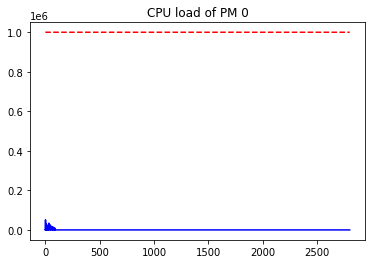

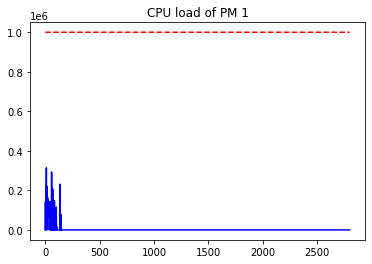

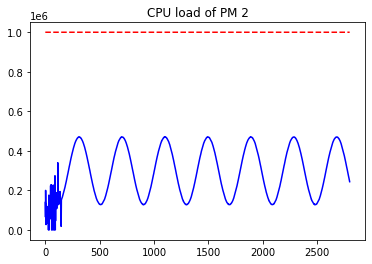

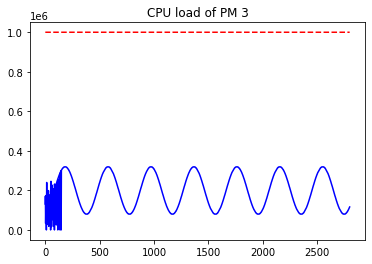

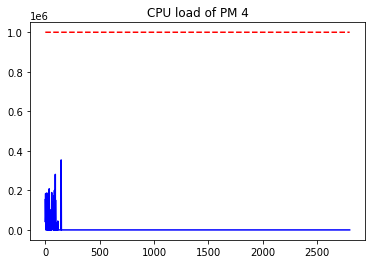

In [44]:
pm_usage = np.array(pm_usage)
for i in range(N_PM):
    plt.figure()
    plt.title(f'CPU load of PM {i}')
    plt.plot(pm_usage[200:,i], 'b')
    plt.plot([1000000]*(len(pm_usage)-200), 'r--')


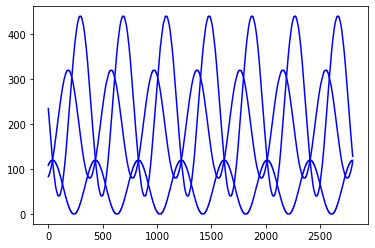

In [45]:

requestsHistory = np.array(requestsHistory)
plt.figure()
for i in range(N_APPS):
    plt.plot(requestsHistory[200:,i], 'b')


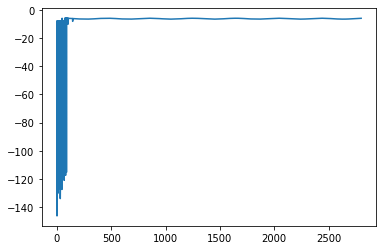

In [46]:

plt.figure()
plt.plot(rewards[200:])
plt.show()

In [47]:
# testing

rewards = []
pm_usage = []
requestsHistory = []
simulation = Simulation()
for _ in tqdm.tqdm(range(500)):
    # get old state
    state_old = agent.get_state(simulation)

    # get move
    final_move = agent.get_model_action(state_old)

    # perform move and get new state
    reward, pm_requests, requests = simulation.tick(final_move) # TODO get more data to plot
    state_new = agent.get_state(simulation)

    # train short memory
    agent.train_short_memory(state_old, final_move, reward, state_new)

    # remember
    agent.remember(state_old, final_move, reward, state_new)

    # TODO make long term memory

    
    rewards.append(reward)
    pm_usage.append(pm_requests)
    requestsHistory.append(requests)



100%|██████████| 500/500 [00:09<00:00, 50.63it/s]


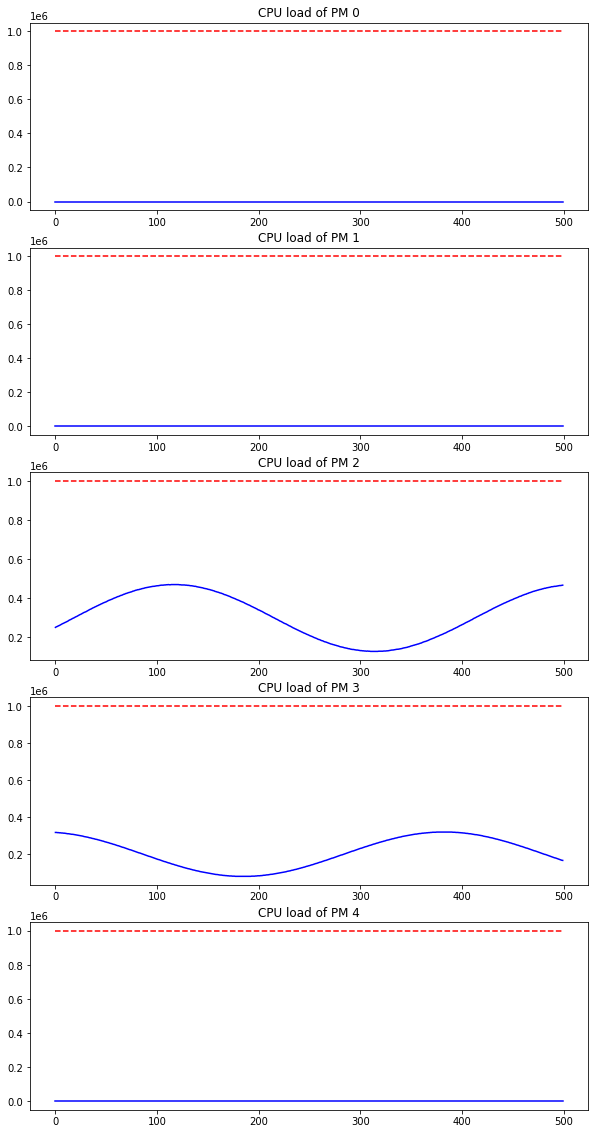

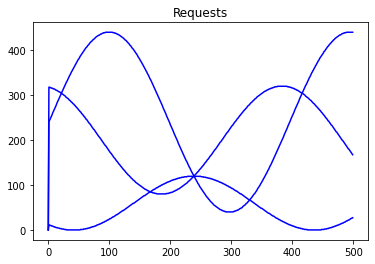

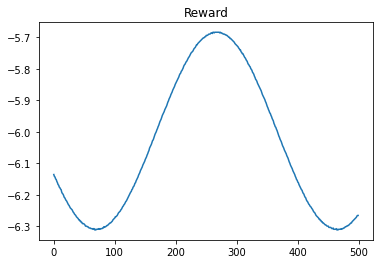

In [48]:
pm_usage = np.array(pm_usage)
fig, axs = plt.subplots(5, 1, figsize=(10, 20))

# Plot CPU load of PMs
for i in range(N_PM):
    axs[i].plot(pm_usage[:, i], 'b')
    axs[i].plot([1000000] * len(pm_usage), 'r--')
    axs[i].set_title(f'CPU load of PM {i}')


requestsHistory = np.array(requestsHistory)
plt.figure()
plt.title('Requests')
for i in range(N_APPS):
    plt.plot(requestsHistory[:,i], 'b')


plt.figure()
plt.title('Reward')
plt.plot(rewards)
plt.show()